This file accompanies the book `Kramers-Kronig Relations in Optical Materials Research` by Lucarini, V., Saarinen, J.J., Peiponen, K.-E., Vartiainen, E.M. Springer, Heidelberg, 2005 where the theory and applications are fully developed. 

This software is distributed under the GNU licence agreement by `Valerio Lucarini`

email: lucarini@alum.mit.edu

University of Camerino Department of Mathematics and Computer Science Camerino, Italy.

`inputs:`

the vector of the frequency (or energy) components, 

the vector of the imaginary part of the susceptibility under examination, 

the value of the moment considered. 

`output:`

the estimate of the real part as obtained with K-K relations.

* The two vectors must have the same length and the frequency vector omega must be equispaced, if not, apply MATLAB functions such as interp. 

* If imchi is the imaginary part of a linear susceptibility, alpha must be 0. 

* If imchi is the imaginary part of the nth harmonic generation susceptibility, alpha=0,1,..2n. 

* If imchi is the imaginary part of a pump and probe susceptibility, alpha=0 or 1.

[Kramers-Kronig transformation on the frequency-dependant imaginary dielectric function, to obtain the real part of the dielectric function](https://github.com/utf/kramers-kronig)

* 1) real_chi3 = KK(frequency,img_chi3=Raman,alpha=0)

* 2) chi3 = real_chi3 + (1j) * img_chi3

* 3) CARS = |chi3+`background`|^2 + noise

`background can be (constant,linear,nonlinear)`

I am thinking what could be the best strategy/goal for the deep learning algorithm
to `CARS spectroscopy`. To the user point of view I see two goals:

* (1) given a CARS spectrum `S(x) = |chi_nr + b(x) + chi_R(x)|^2 + noise`, it could produce a background corrected spectrum with only constant background term chi_nr: `S'(x) = |chi_nr + chi_R(x)|^2 (+ noise)`


* (2) given a background corrected spectrum `S'(x) = |chi_nr + chi_R(x)|^2`, it could produce background suppressed line-shape `S''(x) = |chi_R(x)|^2`


* Namely, `|chi_R(x)|^2` gives basically the same information as the Raman line shape `Im[S'(x)] = Im[S''(x)]`.


* Obviously, (1) needs set of S(x)'s and S'(x)'s for teaching the algorithm and (2) set of  S'(x)'s and S''(x)'s.

![img_deeplearning_CARS.png](img_deeplearning_CARS.png)

In [1]:
import numpy as np
from numpy import genfromtxt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.io
import csv
import pickle
import random
from itertools import chain

import os
import sys
import glob
np.set_printoptions(threshold=sys.maxsize)
from operator import add

from BaselineRemoval import BaselineRemoval
from class_KKrelations import kkrebook

from scipy.signal import chirp, find_peaks, peak_widths, peak_prominences
from sklearn.model_selection import train_test_split

C:\Users\alisa\.conda\envs\tensorflow_env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\alisa\.conda\envs\tensorflow_env\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\alisa\.conda\envs\tensorflow_env\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### generate semi-synthetic spectra

In [4]:
max_features = 20
n_points = 640
nu = np.linspace(0,1,n_points)

def sigmoid_our(x,c,b):
    return 1/(1+np.exp(-(x-c)*b))

def generate_nrb_our(wavenumber):
    """
    produces a normalized shape for the NRB
    outputs
        NRB: (n_points,)
    """
    bs = np.random.normal(10,5,2)
    c1 = np.random.normal(0.2,0.3)
    c2 = np.random.normal(0.7,0.3)
    cs = np.r_[c1,c2]
    sig1 = sigmoid_our(wavenumber,cs[0],bs[0])
    sig2 = sigmoid_our(wavenumber,cs[1],-bs[1])
    nrb  = sig1*sig2
    return nrb

def random_chi3_our():
    """
    generates a random spectrum, without NRB. 
    output:
        params =  matrix of parameters. each row corresponds to the [amplitude,resonance,linewidth] of each generated feature
        (n_lor,3)
    """
    n_lor = np.random.randint(1,max_features)
    a = np.random.uniform(0,1,n_lor)
    w = np.random.uniform(0,1,n_lor)
    g = np.random.uniform(0.001,0.04,n_lor)
    
    params = np.c_[a,w,g]
    return params

def build_chi3_our(params):
    """
    buiilds the normalized chi3 complex vector
    inputs: 
        params: (n_lor, 3)
    outputs
        chi3: complex, (n_points, )
    """
    
    chi3 = np.sum(params[:,0]/(-nu[:,np.newaxis]+params[:,1]-1j*params[:,2]),axis=1)
    
    return chi3/np.max(np.abs(chi3))

def get_spectrum_our():
    """
    produces a cars spectrum.
    it outputs the normalized cars and the corresponding imaginary part.
    outputs
        cars: (n_points,)
        chi3.imag: (n_points,)
    """
    chi3 = build_chi3_our(random_chi3_our())*np.random.uniform(0.3,1)
    nrb = generate_nrb_our(nu)
    noise = np.random.randn(n_points)*np.random.uniform(0.0005,0.003)
    cars = (np.abs(chi3+nrb)**2)/2 + noise
    return cars, chi3.imag

def generate_batch_our(size=10000):
    X = np.empty((size,n_points,1))
    y = np.empty((size,n_points))
    for i in range(size):
        X[i,:,0], y[i,:] = get_spectrum_our()
    return X, y

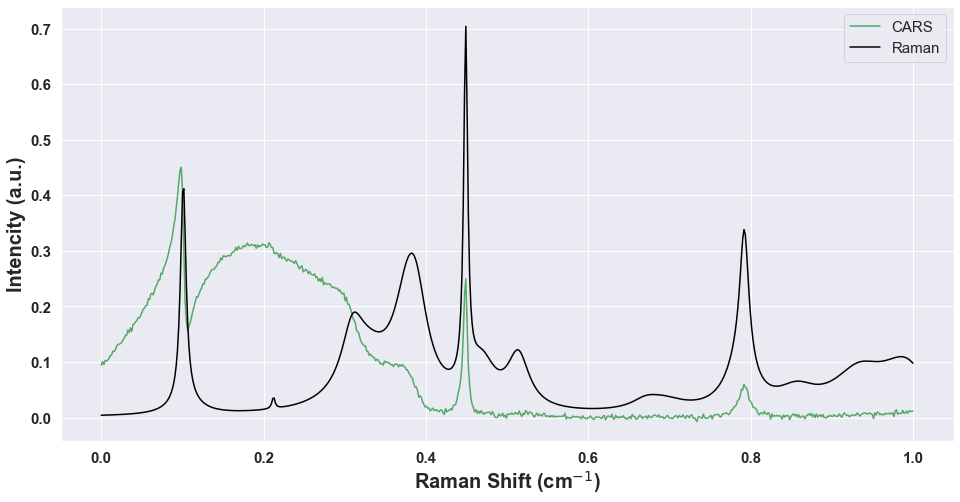

In [5]:
# cars, imag, chi3, nrb, noise = get_spectrum_simulated()
cars, imag = get_spectrum_our()

plt.figure(figsize=(16,8))
plt.plot(nu,cars,'g',label='CARS')
plt.plot(nu,imag,'black',label='Raman')
# plt.plot(nu,chi3,'k',label='chi3')
# plt.plot(nu,nrb,'g',label='nrb')
# plt.plot(nu,noise,'y',label='noise')
plt.xlabel("Raman Shift (cm$^{-1}$)",fontweight='bold',fontsize=20)
plt.xticks(fontweight='bold',fontsize=15)
plt.ylabel("Intencity (a.u.)",fontweight='bold',fontsize=20)
plt.yticks(fontweight='bold',fontsize=15)
plt.legend(fontsize=15)
plt.show()

### plotting raw version of 120 tablet Raman spectra

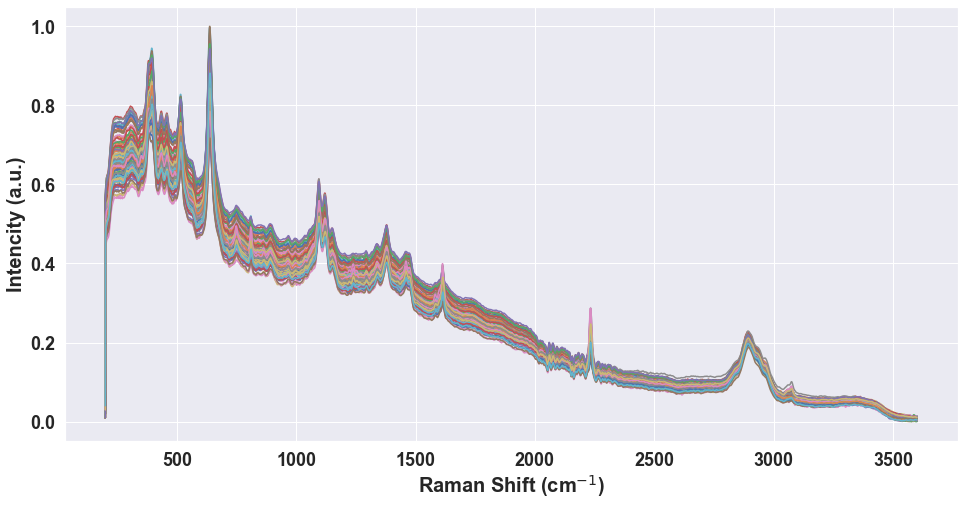

In [6]:
# reading tablets_raman 
tablets_raman = pd.read_csv("tablets_raman.csv",header=None)
tablets_raman_np1 = tablets_raman.to_numpy()
tablets_raman_np2 = np.empty(tablets_raman_np1.shape)
for i in range(0,tablets_raman_np2.shape[0]):
    tablets_raman_np2[i] = tablets_raman_np1[i][::-1]
tablets_raman_df = pd.DataFrame(tablets_raman_np2)

# wavenumbers of tablets_raman [200,3600](1/cm)
tablets_wavenumber = np.linspace(200,3600,3402)

# min_max of raman sample
raman = tablets_raman_df.values
minmax_raman = (raman-raman.min())/(raman.max()-raman.min())

# plotting with scaling
plt.figure(figsize=(16,8))
plt.plot(tablets_wavenumber,minmax_raman.T)
#plt.title("120 normalized tablets Raman spectra")
plt.xlabel("Raman Shift (cm$^{-1}$)",fontweight='bold',fontsize=20)
plt.xticks(fontweight='bold',fontsize=18)
plt.ylabel("Intencity (a.u.)",fontweight='bold',fontsize=20)
plt.yticks(fontweight='bold',fontsize=18)
plt.show()

### plotting raw, normalized, background_corrected of 48 Raman spectra

In [7]:
def raman_minmax(path="./48_raman_groups/*.csv",sample_num=0,i=0):
    
    """
    plotting both raman spectrum, its min_max version
    and its i'th Zhangfit spectrum!
    
    """
    
    ramans_48 = glob.glob(path)
    sample_path = ramans_48[sample_num]
    sample_name = ramans_48[sample_num].split("\\")[1].split(".")[0]

    # raman sample
    raman_df = pd.read_csv(sample_path,header=None)
    raman_numpy = raman_df.to_numpy()
    raman_wn = raman_numpy[:,0]
    raman = raman_numpy[:,1:]
    #print("shape of data  :",raman.shape,"\n")
    
    # min_max of raman sample
    minmax_raman = (raman-raman.min())/(raman.max()-raman.min())
    
    # 640 data points
    n_points = 640
    nu = np.linspace(0,1,n_points)
    
    # backgroud-corrected example
    baseObj_raman_i = BaselineRemoval(raman[:,i])
    Zhangfit_i = baseObj_raman_i.ZhangFit()
    
    # min_max normalization
    minmax_Zhangfit_i = (Zhangfit_i-Zhangfit_i.min())/(Zhangfit_i.max()-Zhangfit_i.min())
    print("original data points:",minmax_Zhangfit_i.shape[0])

    # plotting 
    plt.figure(figsize=(16,14))
    plt.subplot(5,1,1)
    plt.plot(raman_wn,raman,label='raw raman')
    plt.ylabel("Intencity (a.u.)",fontsize=18)
    plt.subplot(5,1,3)
    plt.plot(raman_wn,Zhangfit_i,'k',label='Zhangfit_i')
    plt.title(sample_name,fontsize=18)
    plt.legend()
    plt.subplot(5,1,4)
    plt.plot(raman_wn,minmax_Zhangfit_i,'r',label='normalized_Zhangfit_i')
    plt.ylabel("Intencity (a.u.)",fontsize=18)
    plt.legend()
    plt.subplot(5,1,5)
    plt.plot(nu,minmax_Zhangfit_i[200:200+n_points],'g',label='640_Zhangfit_i')
    plt.xlabel("Raman Shift (cm$^{-1}$)",fontsize=18)
    plt.legend()
    plt.show()

original data points: 933


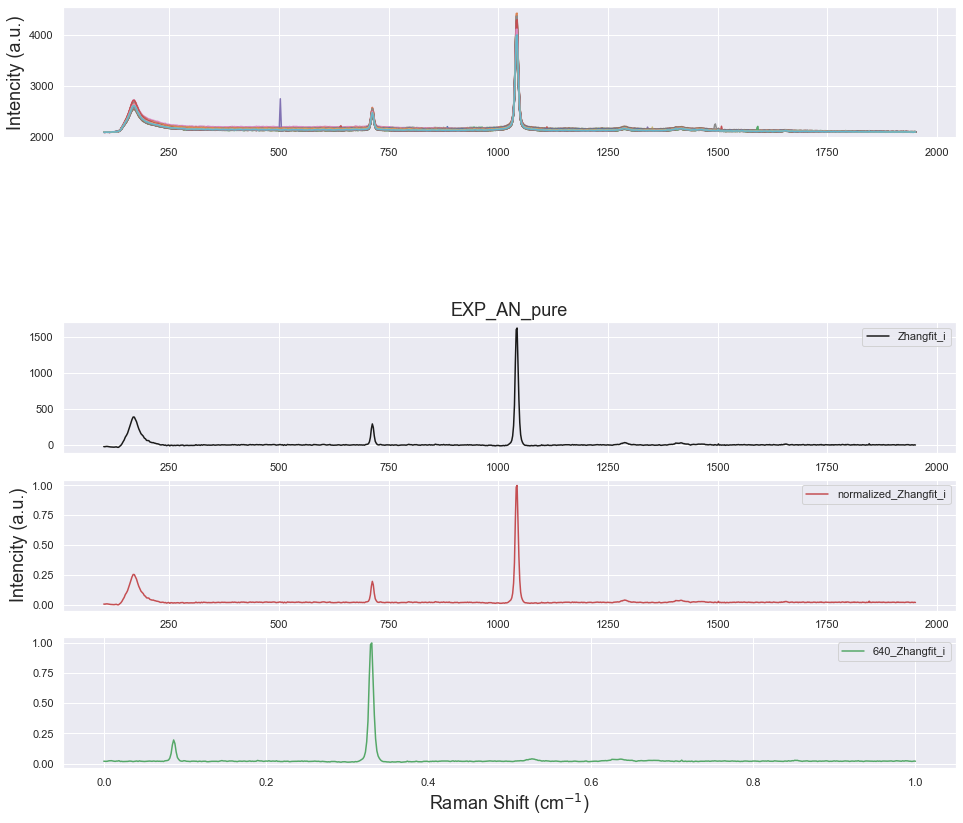

In [8]:
# an example
raman_minmax(sample_num=0)

### background-correction of 48 different Raman groups

In [19]:
def background_correction(path="./48_raman_groups/*.csv",sample_num=0,plot=1,seed=0):
    """
    background-correction of 48 different Raman samples!
    """
    
    np.random.seed(seed)
    
    ramans_48 = glob.glob(path)
    sample_path = ramans_48[sample_num]
    sample_name = ramans_48[sample_num].split("\\")[1].split(".")[0]

    # raman sample
    raman_df = pd.read_csv(sample_path,header=None)
    raman_numpy = raman_df.to_numpy()
    raman_wn = raman_numpy[:,0]
    n_points = raman_wn.shape[0]
    nu = np.linspace(0,1,n_points)
    raman = np.transpose(raman_numpy[:,1:])
    if raman.shape[0] > 5:
        index = np.random.randint(0,raman.shape[0],5)
        raman = raman[index,:]
    print(sample_name)
    print("shape of data:",raman.shape,"\n")
    
    # min_max of raman sample
    minmax_raman = (raman-raman.min())/(raman.max()-raman.min())
    
    # backgroud-corrected raman spectrum and remove its negative values
    no0s_minmax_Zhangfit = np.empty(minmax_raman.shape)
    no0s_minmax_real_Zhangfit = np.empty(minmax_raman.shape)
    chi3 = np.empty(minmax_raman.shape)
    cars = np.empty(minmax_raman.shape)
    for i in range(0,minmax_raman.shape[0]):
        baseObj_raman_i = BaselineRemoval(minmax_raman[i])
        minmax_Zhangfit_i = baseObj_raman_i.ZhangFit()
        no0s_minmax_Zhangfit_i = minmax_Zhangfit_i + (-minmax_Zhangfit_i.min())
        no0s_minmax_Zhangfit[i] = no0s_minmax_Zhangfit_i
        no0s_minmax_real_Zhangfit[i] = kkrebook(nu,no0s_minmax_Zhangfit_i,0)
    
    chi3 = no0s_minmax_real_Zhangfit + (1j)*no0s_minmax_Zhangfit
    
    if plot==1:
        # plotting 
        plt.figure(figsize=(16,14))
        plt.subplot(2,1,1)
        plt.plot(nu,minmax_raman.T)
        plt.title(sample_name)
        plt.ylabel("Intensity")
        plt.subplot(2,1,2)
        plt.plot(nu,no0s_minmax_Zhangfit[0].T,'b',label='Zhangfit_0')
        plt.plot(nu,chi3[0].T,'g',label='chi3_0')
        plt.plot(nu,cars[0].T,'y',label='cars_0')
        plt.plot(nu,nrb,'r',label='nrb')
        plt.legend()
        plt.ylabel("Intensity")
        plt.xlabel("Wavenumbers (1/cm)")
        plt.show()
        
    return chi3

### data division with fixed seed

In [21]:
def data_division(seed=0):
    
    
    # 1) seperating the groups with 1 and omre than 1 spectrums
    chi3_one_spectrum = []
    chi3_more_spectrum = []
    for i in range(len(chi3_48)):
        # groups with 1 spectrum
        if chi3_48[i].shape[0] == 1:
            chi3_one_spectrum.append(chi3_48[i])
        # groups with more than 1 spectrums
        if chi3_48[i].shape[0] > 1:
            chi3_more_spectrum.append(chi3_48[i])

            
    # 2) leave-one-out method for train-test
    chi3_one_spectrum_train = []
    chi3_one_spectrum_test = []
    chi3_more_spectrum_train = []
    chi3_more_spectrum_test = []
    # chi3_one_spectrum
    random.seed(seed)
    test_index = []
    test_index = random.sample(range(10),5)
    test_index = sorted(test_index,reverse=True)

    for idx in test_index:
        if idx < len(chi3_one_spectrum):
            chi3_one_spectrum_train.append(chi3_one_spectrum[idx])
            chi3_one_spectrum.pop(idx)
    chi3_one_spectrum_test =  chi3_one_spectrum
    # chi3_more_spectrum
    np.random.seed(seed)
    for i in range(len(chi3_more_spectrum)):
        test_index = np.random.randint(0,chi3_more_spectrum[i].shape[0])
        chi3_more_spectrum_test.append(chi3_more_spectrum[i][test_index])
        chi3_more_spectrum_train.append(np.delete(chi3_more_spectrum[i],test_index,axis=0))

        
    # 3) creating train and test sets in a way that if:
    #    a) the group has 1 spectrum, that spectrum must goes to either test or train set! 
    #    b) the group has more than 1 spectrums, 1 random spectrum goes to test set and the rest go to train set!
    chi3_spectrum_train = chi3_one_spectrum_train + chi3_more_spectrum_train
    chi3_spectrum_test = chi3_one_spectrum_test + chi3_more_spectrum_test


    # 4) cutting chi3 spectrums between [start_wn:start_wn+640]
    n_points = 640
    nu = np.linspace(0,1,n_points)
    r_chi3_train = np.empty((0,n_points))
    r_chi3_test = np.empty((0,n_points))
    start_wn = 200
    for i in range(len(chi3_spectrum_train)):
        for j in range(chi3_spectrum_train[i].shape[0]):
            r_chi3_train = np.append(r_chi3_train,[chi3_spectrum_train[i][j][start_wn:start_wn+n_points]],axis=0)
    for i in range(len(chi3_spectrum_test)):
        chi3_spectrum_test[i] = chi3_spectrum_test[i].reshape(1,-1)
        for j in range(chi3_spectrum_test[i].shape[0]):
            r_chi3_test = np.append(r_chi3_test,[chi3_spectrum_test[i][j][start_wn:start_wn+n_points]],axis=0)
    
    
    # 5) tablet data
    no0s_minmax_Zhangfit_120_df = pd.read_csv("no0s_minmax_Zhangfit_120.csv",header=None)
    no0s_minmax_real_Zhangfit_120_df = pd.read_csv("no0s_minmax_real_Zhangfit_120.csv",header=None)
    no0s_minmax_Zhangfit_120 = no0s_minmax_Zhangfit_120_df.to_numpy()
    no0s_minmax_real_Zhangfit_120 = no0s_minmax_real_Zhangfit_120_df.to_numpy()
    no0s_minmax_chi3_Zhangfit_120 = no0s_minmax_real_Zhangfit_120 + (1j)*no0s_minmax_Zhangfit_120
    #no0s_minmax_chi3_Zhangfit_aug = np.repeat(no0s_minmax_chi3_Zhangfit_120,1,axis=0)
    random.seed(seed)
    idx_train = random.sample(range(120),5)
    idx_test = idx_train.pop(0)
    t_chi3_train = np.empty((0,n_points))
    t_chi3_test = np.empty((0,n_points))
    t_chi3_train = no0s_minmax_chi3_Zhangfit_120[idx_train]
    t_chi3_test = no0s_minmax_chi3_Zhangfit_120[idx_test].reshape(1,-1)
    
    
    # 6) concatenate rajendhar to tablet sets
    np.random.seed(seed)
    mix_chi3_train = np.concatenate((r_chi3_train,t_chi3_train))
    np.random.shuffle(mix_chi3_train)
    mix_chi3_test = np.concatenate((r_chi3_test,t_chi3_test))
    np.random.shuffle(mix_chi3_test)
    
    
    # 7) concatenate mix_chi3_train to mix_chi3_test sets to have all 199 samples
    np.random.seed(seed)
    mix_chi3 = np.concatenate((mix_chi3_train,mix_chi3_test))
    np.random.shuffle(mix_chi3)
    mix_imag = np.empty((mix_chi3.shape[0],mix_chi3.shape[1]))
    for i in range(mix_chi3.shape[0]):
        mix_imag[i] = mix_chi3.imag[i]
    
    # 8) creating CARS, Raman and chi3 for train, test sets!
    n_points = 640
    nu = np.linspace(0,1,n_points)
    # X, y, X_train, y_train, X_test, y_test
    #X = np.empty((mix_chi3.shape[0],mix_chi3.shape[1],1))
    #y = np.empty((mix_chi3.shape[0],mix_chi3.shape[1]))
    X_train = np.empty((mix_chi3_train.shape[0],mix_chi3_train.shape[1],1))
    y_train = np.empty((mix_chi3_train.shape[0],mix_chi3_train.shape[1]))
    X_test = np.empty((mix_chi3_test.shape[0],mix_chi3_test.shape[1],1))
    y_test = np.empty((mix_chi3_test.shape[0],mix_chi3_test.shape[1]))
    
    for i in range(mix_chi3_train.shape[0]):
        nrb = generate_nrb(nu)
        #noise = np.random.randn(n_points)*np.random.uniform(0.0005,0.003)
        #X[i,:,0] = (np.abs(V[i]+nrb)**2)/2 + noise
        X_train[i,:,0] = (np.abs(mix_chi3_train[i]+nrb)**2)/2
        y_train[i] = mix_chi3_train.imag[i]
     
    for i in range(mix_chi3_test.shape[0]):
        nrb = generate_nrb(nu)
        #noise = np.random.randn(n_points)*np.random.uniform(0.0005,0.003)
        #X[i,:,0] = (np.abs(V[i]+nrb)**2)/2 + noise
        X_test[i,:,0] = (np.abs(mix_chi3_test[i]+nrb)**2)/2
        y_test[i] = mix_chi3_test.imag[i]
    
    return mix_chi3, mix_chi3_train, mix_chi3_test, X_train, y_train, X_test, y_test

In [22]:
# results
mix_chi3, mix_chi3_train, mix_chi3_test, cars_train, raman_train, cars_test, raman_test = data_division(seed=43)
mix_chi3.shape, mix_chi3_train.shape, mix_chi3_test.shape, cars_train.shape, raman_train.shape, cars_test.shape, raman_test.shape

((199, 640),
 (155, 640),
 (44, 640),
 (155, 640, 1),
 (155, 640),
 (44, 640, 1),
 (44, 640))

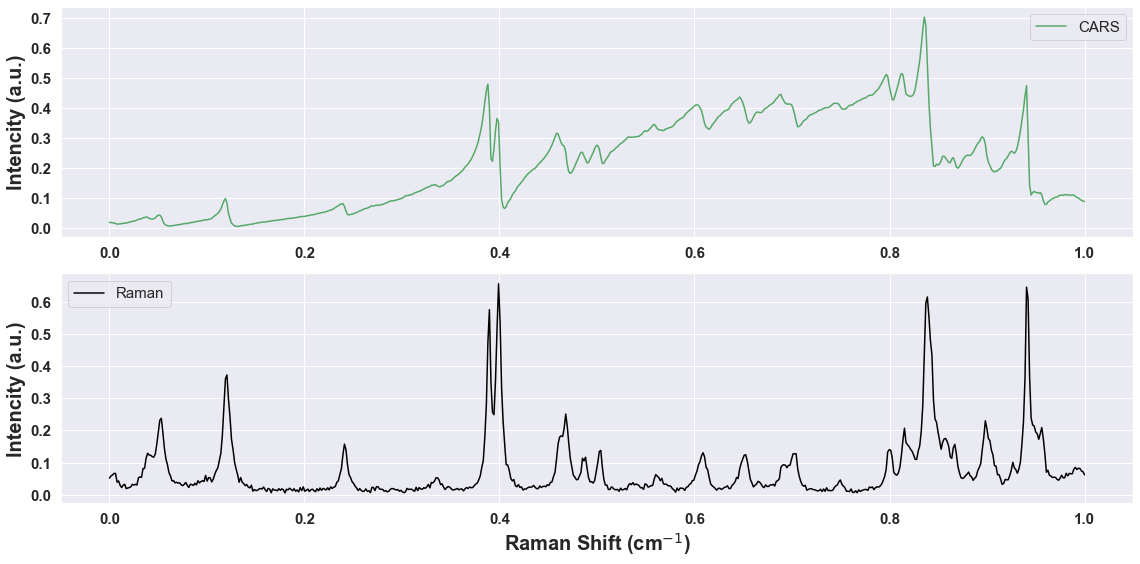

In [23]:
# just an example of one of the 155 experimental samples
i = 61
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.plot(nu,cars_train[i].flatten(),'g',label='CARS')
#plt.title("sample 35")
plt.ylabel("Intencity (a.u.)",fontweight='bold',fontsize=20)
plt.yticks(fontweight='bold',fontsize=15)
plt.xticks(fontweight='bold',fontsize=15)
plt.legend(fontsize=15)
plt.subplot(2,1,2)
plt.plot(nu,raman_train[i].T,'black',label='Raman')
plt.legend(fontsize=15)
plt.subplots_adjust(hspace=0)
plt.ylabel("Intencity (a.u.)",fontweight='bold',fontsize=20)
plt.yticks(fontweight='bold',fontsize=15)
plt.xlabel("Raman Shift (cm$^{-1}$)",fontweight='bold',fontsize=20)
plt.xticks(fontweight='bold',fontsize=15)
plt.tight_layout()
plt.show()

### distribution of peaks and linwidths of train set! (raman_train)

In [24]:
list_peaks = []
all_peaks = []
list_widths = []
all_widths = []

for i in range(raman_train.shape[0]):
    spectrum = raman_train[i]
    denoised_spectrum = pd.Series(spectrum).rolling(window=7).mean()
    
    peaks, _ = find_peaks(denoised_spectrum,height=0.1,threshold=None,distance=None,prominence=None,
                          width=None,wlen=None,rel_height=0.5,plateau_size=None)
    list_peaks.append(peaks.shape[0])
    
    results_half = peak_widths(denoised_spectrum,peaks,rel_height=0.5)
    list_widths.append(results_half[0])
    
all_peaks = list_peaks
all_widths = [item for sublist in list_widths for item in sublist]

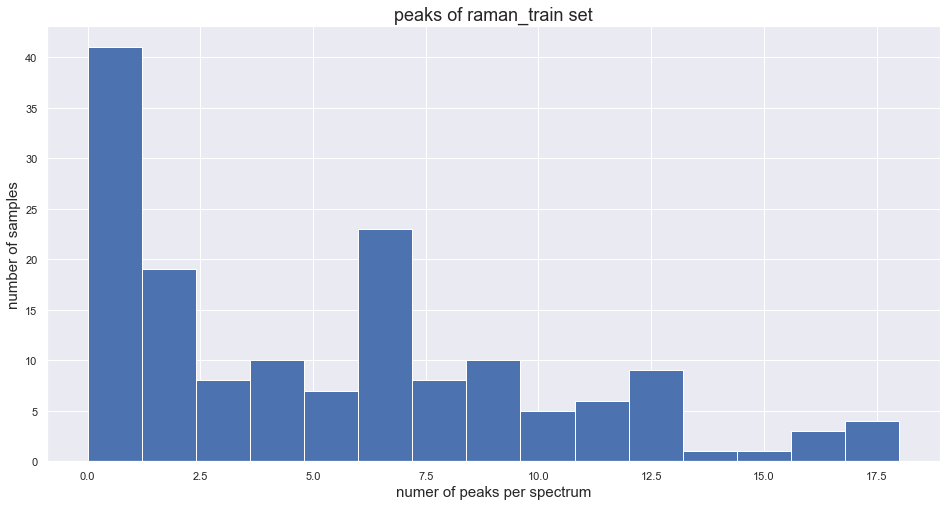

In [25]:
# plotting
plt.figure(figsize=(16,8))
plt.hist(all_peaks,bins=15)
plt.title("peaks of raman_train set",fontsize=18)
plt.xlabel("numer of peaks per spectrum",fontsize=15)
plt.ylabel("number of samples",fontsize=15)
plt.show()

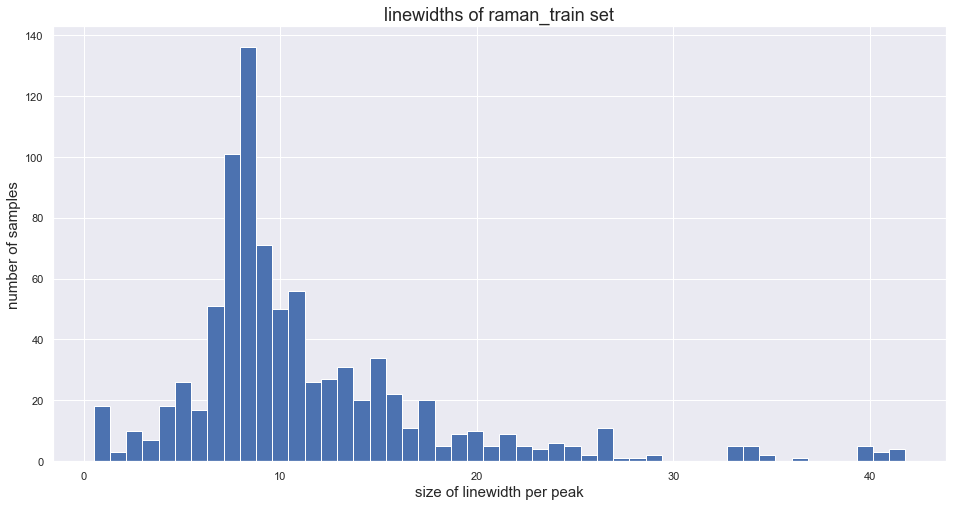

In [26]:
# plotting
plt.figure(figsize=(16,8))
plt.hist(all_widths,bins=50)
plt.title("linewidths of raman_train set",fontsize=18)
plt.xlabel("size of linewidth per peak",fontsize=15)
plt.ylabel("number of samples",fontsize=15)
plt.show()

### Kernel Density Estimation (KDE)

[KDE solution_1](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html)

[KDE solution_2](https://scikit-learn.org/stable/modules/density.html)

[A Gentle Introduction to Probability Density Estimation](https://machinelearningmastery.com/probability-density-estimation/#:~:text=of%20the%20density.-,Parametric%20Density%20Estimation,-The%20shape%20of)

[How to plot this distribution with percentage of data as label in each band/bin?](https://stackoverflow.com/questions/49630427/how-to-plot-normal-distribution-with-percentage-of-data-as-label-in-each-band-bi)

[Confidence Interval](https://dfrieds.com/math/confidence-intervals.html)

In [27]:
from scipy import stats
from scipy.stats import norm, gaussian_kde
from sklearn.neighbors import KernelDensity

#### peaks

In [28]:
mean_peaks = np.mean(all_peaks)
stdev_peaks = np.std(all_peaks)
size_peaks = len(all_peaks)
print("mean of samples  :",mean_peaks)
print("stdev of samples :",stdev_peaks)
print("number of samples:",size_peaks)
all_peaks_np = np.asarray(all_peaks)
median, q1, q3 = np.percentile(all_peaks_np,50), np.percentile(all_peaks_np,5), np.percentile(all_peaks_np,95)
print("median, q1, q3   :",median,q1,q3)

mean of samples  : 5.516129032258065
stdev of samples : 4.599235334353965
number of samples: 155
median, q1, q3   : 4.0 0.7000000000000002 14.299999999999983


In [29]:
# specifying the kernel
scipy_kernel = gaussian_kde(all_peaks)
print(type(scipy_kernel))

# finding the bandwidth
bw = scipy_kernel.factor * np.std(all_peaks)
print("bandwidth:",bw)

<class 'scipy.stats.kde.gaussian_kde'>
bandwidth: 1.6773330044099337


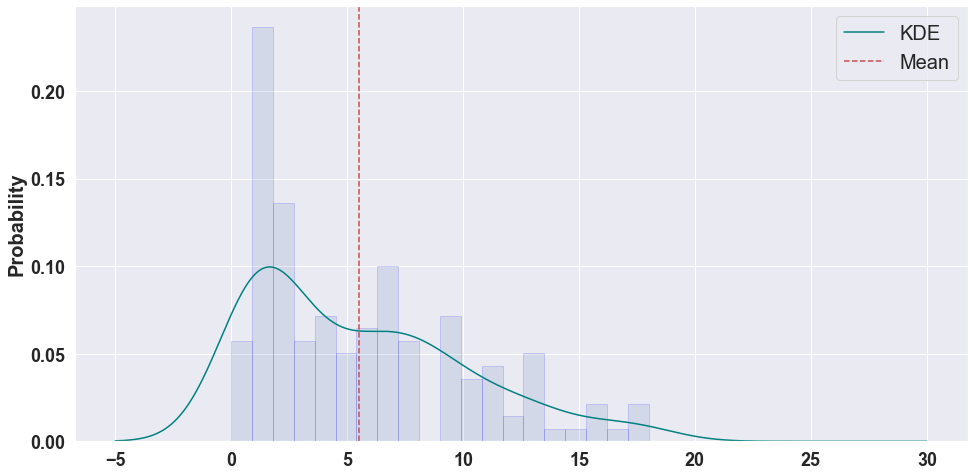

In [30]:
n_bins = 20
kde = stats.gaussian_kde(all_peaks_np)
pos = np.linspace(-5.0,30.0,10000)
shade = np.linspace(q1,q3,300)

# plotting
plt.figure(figsize=(16,8))
#plt.title("kernel density estimation of peaks",fontsize=18)
n, bins, patches = plt.hist(all_peaks_np,n_bins,density=True,alpha=0.15,edgecolor='blue')
plt.plot(pos,kde(pos),color='teal',label='KDE')
plt.axvline(x=mean_peaks,color='r',linestyle='--',label='Mean')
#plt.axvline(x=bw,color='k',linestyle='--',label='Bandwidth')
#plt.fill_between(shade,kde(shade),alpha=0.5,color='teal')
#plt.annotate('2.5%',xy=(q1-0.5,norm(mean_peaks,stdev_peaks).pdf(q1)-0.015),ha='center')
#plt.annotate('97.5%',xy=(q3,norm(mean_peaks,stdev_peaks).pdf(q3)+0.015),ha='center')
plt.ylabel("Probability",fontweight='bold',fontsize=20)
plt.yticks(fontweight='bold',fontsize=18)
#plt.xlabel("Peaks",fontsize=18)
plt.xticks(fontweight='bold',fontsize=18)
plt.legend(fontsize=20)
plt.show()

#### linewidths

In [31]:
mean_widths = np.mean(all_widths)
stdev_widths = np.std(all_widths)
size_widths = len(all_widths)
print("mean of samples  :",mean_widths)
print("stdev of samples :",stdev_widths)
print("number of samples:",size_widths)
all_widths_np = np.asarray(all_widths)
median, q1, q3 = np.percentile(all_widths_np,50), np.percentile(all_widths_np,5), np.percentile(all_widths_np,95)
print("median, q1, q3   :",median,q1,q3)

mean of samples  : 11.363045201873136
stdev of samples : 6.782924121962211
number of samples: 855
median, q1, q3   : 9.177974557636702 4.185326801045937 24.97891219880696


In [32]:
# specifying the kernel
scipy_kernel = gaussian_kde(all_widths)
print(type(scipy_kernel))

# finding the bandwidth
bw = scipy_kernel.factor * np.std(all_widths)
print("bandwidth:",bw)

<class 'scipy.stats.kde.gaussian_kde'>
bandwidth: 1.7580196938412813


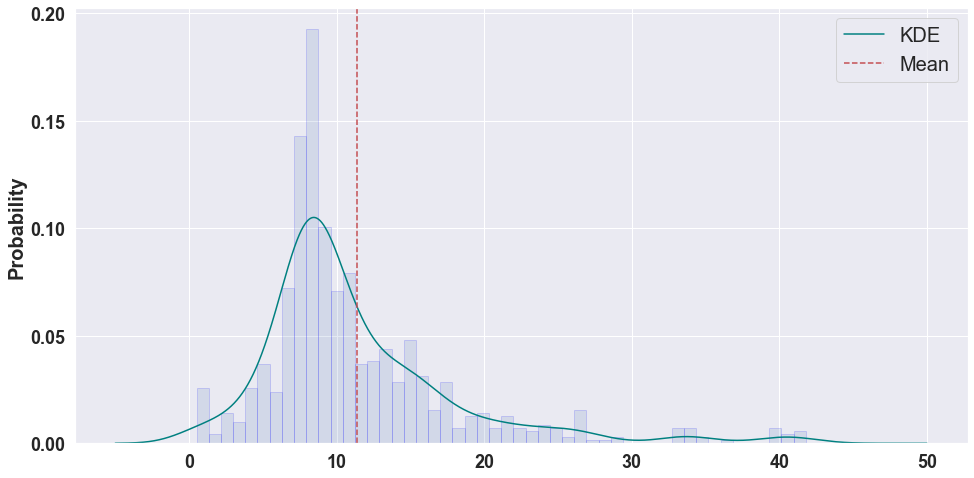

In [33]:
n_bins = 50
kde = stats.gaussian_kde(all_widths_np)
pos = np.linspace(-5.0,50.0,10000)
shade = np.linspace(q1,q3,300)

# plotting
plt.figure(figsize=(16,8))
#plt.title("kernel density estimation of linewidths",fontsize=18)
n, bins, patches = plt.hist(all_widths_np,n_bins,density=True,alpha=0.15,edgecolor='blue')
plt.plot(pos,kde(pos),color='teal',label='KDE')
plt.axvline(x=mean_widths,color='r',linestyle='--',label='Mean')
#plt.axvline(x=bw,color='k',linestyle='--',label='Bandwidth')
#plt.fill_between(shade,kde(shade),alpha=0.5,color='teal')
#plt.annotate('5%',xy=(q1,norm(mean_widths,stdev_widths).pdf(q1)),ha='center')
#plt.annotate('95%',xy=(q3,norm(mean_widths,stdev_widths).pdf(q3)+0.005),ha='center')
plt.ylabel("Probability",fontweight='bold',fontsize=20)
plt.yticks(fontweight='bold',fontsize=18)
plt.locator_params(axis='y',nbins=7)
#plt.xlabel("Peaks",fontsize=18)
plt.xticks(fontweight='bold',fontsize=18)
plt.legend(fontsize=20)
plt.show()

### SpecNet, custom_SpecNet, finetuned_SpecNet

In [34]:
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv1D, Flatten, BatchNormalization, Activation, Dropout, MaxPooling1D, Reshape, GaussianNoise
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger
import time
from sklearn import metrics

In [35]:
print(tf.__version__)
print(keras.__version__)

2.3.0
2.4.0


In [36]:
tf.keras.backend.clear_session()
n_points = 640

SpecNet = Sequential()
SpecNet.add(BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,beta_initializer='zeros', 
                             gamma_initializer='ones',moving_mean_initializer='zeros',moving_variance_initializer='ones', 
                             beta_regularizer=None,gamma_regularizer=None,beta_constraint=None, 
                             gamma_constraint=None,input_shape=(n_points,1)))
SpecNet.add(Activation('relu'))
SpecNet.add(Conv1D(128,activation='relu',kernel_size=(32)))
SpecNet.add(Conv1D(64,activation='relu',kernel_size=(16)))
SpecNet.add(Conv1D(16,activation='relu',kernel_size=(8)))
SpecNet.add(Conv1D(16,activation='relu',kernel_size=(8)))
SpecNet.add(Conv1D(16,activation='relu',kernel_size=(8)))
SpecNet.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0,l2=0.1)))
SpecNet.add(Dense(16,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0,l2=0.1)))
SpecNet.add(Flatten())
SpecNet.add(Dropout(.25))
SpecNet.add(Dense(n_points,activation='relu'))
SpecNet.compile(loss='mse',
                optimizer='Adam',
                metrics=['mse','mean_absolute_error','accuracy'])

# SpecNet.summary()

In [37]:
# loading SpecNet weights
SpecNet.load_weights("SpecNet_weights.h5")
#SpecNet.load_weights("SpecNet-ourversion_weights.h5")

In [38]:
tf.keras.backend.clear_session()
n_points = 640

blank_SpecNet = Sequential()
blank_SpecNet.add(BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,beta_initializer='zeros', 
                             gamma_initializer='ones',moving_mean_initializer='zeros',moving_variance_initializer='ones', 
                             beta_regularizer=None,gamma_regularizer=None,beta_constraint=None, 
                             gamma_constraint=None,input_shape=(n_points,1)))
blank_SpecNet.add(Activation('relu'))
blank_SpecNet.add(Conv1D(128,activation='relu',kernel_size=(32)))
blank_SpecNet.add(Conv1D(64,activation='relu',kernel_size=(16)))
blank_SpecNet.add(Conv1D(16,activation='relu',kernel_size=(8)))
blank_SpecNet.add(Conv1D(16,activation='relu',kernel_size=(8)))
blank_SpecNet.add(Conv1D(16,activation='relu',kernel_size=(8)))
blank_SpecNet.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0,l2=0.1)))
blank_SpecNet.add(Dense(16,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0,l2=0.1)))
blank_SpecNet.add(Flatten())
blank_SpecNet.add(Dropout(.25))
blank_SpecNet.add(Dense(n_points,activation='relu'))
blank_SpecNet.compile(loss='mse',
                optimizer='Adam',
                metrics=['mse','mean_absolute_error','accuracy'])

# blank_SpecNet.summary()

In [39]:
# loading blank_SpecNet weights
blank_SpecNet.load_weights("blank_SpecNet_aug_semisynthetic_10_randomNRB_weights.h5")
#blank_SpecNet.load_weights("blank_SpecNet-ourversion_weights.h5")

In [45]:
tf.keras.backend.clear_session()
n_points = 640

finetuned_SpecNet = Sequential()
finetuned_SpecNet.add(BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,beta_initializer='zeros',
                               gamma_initializer='ones',moving_mean_initializer='zeros',moving_variance_initializer='ones',
                               beta_regularizer=None,gamma_regularizer=None,beta_constraint=None,gamma_constraint=None,
                               input_shape =(n_points,1)))
finetuned_SpecNet.add(Activation('relu'))
finetuned_SpecNet.add(Conv1D(128,activation='relu',kernel_size=(32)))
finetuned_SpecNet.add(Conv1D(64,activation='relu',kernel_size=(16)))
finetuned_SpecNet.add(Conv1D(16,activation='relu',kernel_size=(8)))
finetuned_SpecNet.add(Conv1D(16,activation='relu',kernel_size=(8)))
finetuned_SpecNet.add(Conv1D(16,activation='relu',kernel_size=(8)))
#1_change: decreasing learning rate from 0.1 to 0.001 to overcome high learning rate?
finetuned_SpecNet.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0,l2=0.1)))
finetuned_SpecNet.add(Dense(16,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0,l2=0.1)))
finetuned_SpecNet.add(Flatten())
#2_change: reduce the dropout rate to overcome randomness or fluctuation?
finetuned_SpecNet.add(Dropout(.25))
finetuned_SpecNet.add(Dense(n_points,activation='relu'))

# finetuned_SpecNet.summary()

[custom metric MAE and RMSE are the same #10706](https://github.com/keras-team/keras/issues/10706)

In [46]:
# loading finetuned_SpecNet
# finetuned_SpecNet.load_weights("synthetic_w_10_500_20_04_003.h5")
#finetuned_SpecNet.load_weights("weights_semisynthetic_10_500_20_04_003.h5")
#finetuned_SpecNet.load_weights("weights_SpecNet_aug_semisynthetic_10_50.h5")
# finetuned_SpecNet.load_weights("SpecNet_aug_semisynthetic_5_10_weights.h5")

finetuned_SpecNet.load_weights("SpecNet_aug_semisynthetic_10_randomNRB_weights.h5")

### finetuned_SpecNet and SpecNet predict semi-synthetic data

In [47]:
# generating our x_test and y_test
def generate_batch_ourdata(size=1,j=0):
    n_points = 640
    nu = np.linspace(0,1,n_points)
    # generating chi3_test and shuffle it around rows
    chi3_test = np.repeat(mix_chi3_test,1,axis=0)
    #np.random.shuffle(chi3_test)
    X_test = np.empty((size,n_points,1))
    y_test = np.empty((size,n_points))
    for i in range(size):
        nrb = generate_nrb(nu)*random.randint(1,4)
        u_noise = np.random.randn(n_points)*np.random.uniform(0.0005,0.003)
        #X_test[i,:,0] = (np.abs(chi3_test[j])**2)/2 + u_noise
        X_test[i,:,0] = (np.abs(chi3_test[j]+nrb)**2)/2 + u_noise
        y_test[i] = chi3_test.imag[j]
    return X_test, y_test

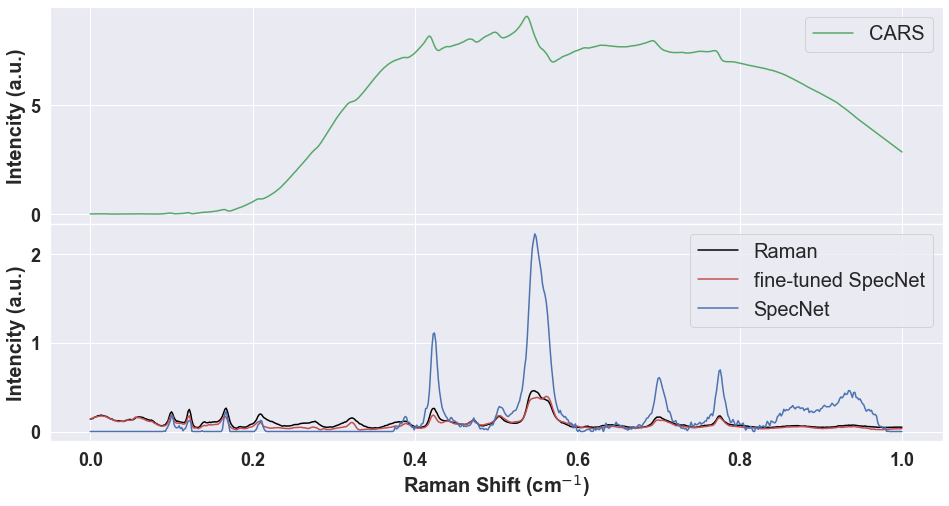

In [48]:
def finetunedspecnet_specnet_ourdata(size=1,j=0):
    x_test, y_test = generate_batch_ourdata(size=size,j=j)
    y_hat = finetuned_SpecNet.predict(x_test,verbose=0)
    specnet_y_hat = SpecNet.predict(x_test,verbose=0)
    plt.figure(figsize=(16,8))
    plt.subplot(2,1,1)
    plt.plot(nu,x_test.flatten(),'g',label='CARS')
    plt.ylabel("Intencity (a.u.)",fontweight='bold',fontsize=20)
    plt.yticks(fontweight='bold',fontsize=18)
    plt.locator_params(axis='y',nbins=3)
    #plt.title("fine-tuned SpecNet and SpecNet predicts our data",fontsize=18)
    plt.legend(fontsize=20)
    plt.subplot(2,1,2)
    plt.plot(nu,y_test.T,'black',label='Raman')
    plt.plot(nu,y_hat.T,'r',label='fine-tuned SpecNet')
    plt.plot(nu,specnet_y_hat.T,'b',label='SpecNet')
    plt.subplots_adjust(hspace=0)
    plt.ylabel("Intencity (a.u.)",fontweight='bold',fontsize=20)
    plt.yticks(fontweight='bold',fontsize=18)
    plt.locator_params(axis='y',nbins=3)
    plt.xlabel("Raman Shift (cm$^{-1}$)",fontweight='bold',fontsize=20)
    plt.xticks(fontweight='bold',fontsize=18)
    plt.legend(fontsize=20)
    plt.show()
    return x_test, y_test, y_hat, specnet_y_hat

x_test, y_test, y_hat, specnet_y_hat = finetunedspecnet_specnet_ourdata(size=1,j=31)

### SNR analysis of semi-synthetic using finetuned_SpecNet and SpecNet

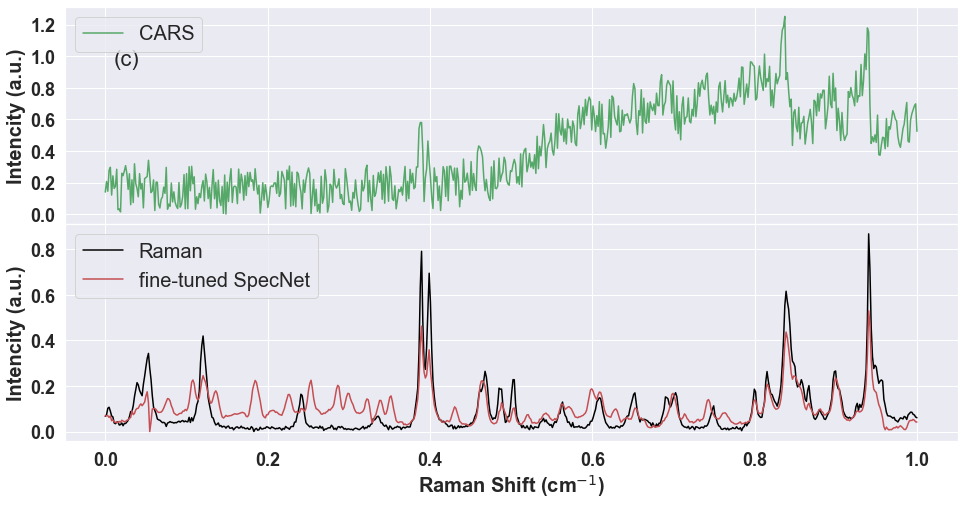

In [52]:
# generating x_test and y_test
def generate_batch_snr(size=1,n=0.003,j=0,seed=0):
    np.random.seed(seed)
    n_points = 640
    nu = np.linspace(0,1,n_points)
    # generating chi3_test and shuffle it around rows
    chi3_test = np.repeat(mix_chi3_test,1,axis=0)
    #np.random.shuffle(chi3_test)
    X_test = np.empty((size,n_points,1))
    y_test = np.empty((size,n_points))
    for i in range(size):
        nrb = generate_nrb(nu)
        #cauchy_noise = np.random.standard_cauchy(size=n_points)
        #normal_noise = np.random.normal(0.0005,0.003,n_points)
        #p_noise = np.random.poisson(lam=5,size=n_points)/(10*(1/n))
        u_noise = np.random.uniform(0.0005,(1*(n)),n_points)
        #X_test[i,:,0] = (np.abs(chi3_test[j])**2)/2 + u_noise
        X_test[i,:,0] = (np.abs(chi3_test[j]+nrb)**2)/2 + u_noise
        y_test[i] = chi3_test.imag[j]
    return X_test, y_test

def our_model_specnet_snr(n=0.003,j=0,seed=0):
    x_test, y_test = generate_batch_snr(size=1,n=n,j=j,seed=0)
    y_hat = finetuned_SpecNet.predict(x_test,verbose=0)
    specnet_y_hat = SpecNet.predict(x_test,verbose=0)
    plt.figure(figsize=(16,8))
    plt.subplot(2,1,1)
    plt.plot(nu,x_test.flatten(),'g',label='CARS')
    plt.ylabel("Intencity (a.u.)",fontweight='bold',fontsize=20)
    plt.yticks(fontweight='bold',fontsize=18)
    plt.legend(fontsize=20)
    plt.text(0.01,0.94,'(c)',fontsize=22)
    #plt.title('level of noise = {}'.format(n))
    plt.subplot(2,1,2)
    plt.plot(nu,y_test.T,'black',label='Raman')
    plt.plot(nu,y_hat.T,'r',label='fine-tuned SpecNet')
    #plt.plot(nu,specnet_y_hat.T,'b',label='SpecNet')
    plt.legend(fontsize=20)
    plt.subplots_adjust(hspace=0)
    plt.ylabel("Intencity (a.u.)",fontweight='bold',fontsize=20)
    plt.yticks(fontweight='bold',fontsize=18)
    plt.xlabel("Raman Shift (cm$^{-1}$)",fontweight='bold',fontsize=20)
    plt.xticks(fontweight='bold',fontsize=18)
    plt.show()
    return x_test, y_test, y_hat, specnet_y_hat

x_test, y_test, y_hat, specnet_y_hat = our_model_specnet_snr(n=0.3,j=36,seed=43)

### SNR analysis for the entire spectra

In [56]:
noises = [0.001,0.003,0.005,0.007,0.009,0.01,0.03,0.05,0.07,0.09,0.1,0.3,0.5,0.7,0.9]
my_dict_mae = {}
my_dict_mse = {}
my_dict_rmse = {}
for noise in noises:
    mae_l = []
    mse_l = []
    rmse_l = []
    for i in range(mix_chi3_test.shape[0]):
        x_test, y_test = generate_batch_snr(size=1,n=noise,j=i,seed=0)
        y_hat = finetuned_SpecNet.predict(x_test,verbose=0)
        mae = metrics.mean_absolute_error(y_test,y_hat)
        mse = metrics.mean_squared_error(y_test,y_hat)
        rmse = np.sqrt(mse) # or mse**(0.5)
        mae_l.append(mae)
        mse_l.append(mse)
        rmse_l.append(rmse)
    my_dict_mae[noise] = [np.mean(mae_l),np.std(mae_l)]
    my_dict_mse[noise] = [np.mean(mse_l),np.std(mse_l)]
    my_dict_rmse[noise] = [np.mean(rmse_l),np.std(rmse_l)]

In [57]:
my_dict_mae_values = []
my_dict_mae_values = list(my_dict_mae.values())
my_dict_mae_means = []
for i in range(len(my_dict_mae_values)):
    my_dict_mae_means.append(my_dict_mae_values[i][0])
    
my_dict_mse_values = []
my_dict_mse_values = list(my_dict_mse.values())
my_dict_mse_means = []
for i in range(len(my_dict_mse_values)):
    my_dict_mse_means.append(my_dict_mse_values[i][0])
    
my_dict_rmse_values = []
my_dict_rmse_values = list(my_dict_rmse.values())
my_dict_rmse_means = []
for i in range(len(my_dict_rmse_values)):
    my_dict_rmse_means.append(my_dict_rmse_values[i][0])

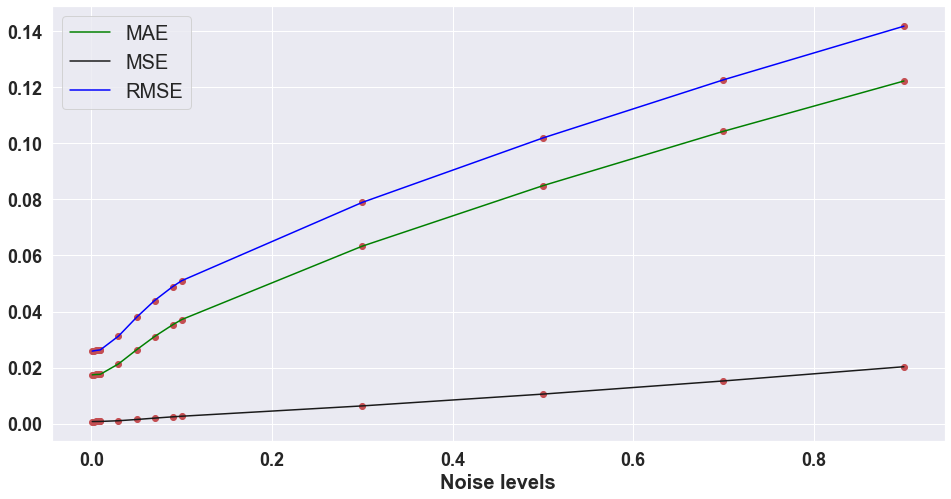

In [58]:
plt.figure(figsize=(16,8))
plt.plot(noises,my_dict_mae_means,'o',color='r')
plt.plot(noises,my_dict_mae_means,color='green',label='MAE')
plt.legend(fontsize=20)
plt.plot(noises,my_dict_mse_means,'o',color='r')
plt.plot(noises,my_dict_mse_means,color='k',label='MSE')
plt.legend(fontsize=20)
plt.plot(noises,my_dict_rmse_means,'o',color='r')
plt.plot(noises,my_dict_rmse_means,color='blue',label='RMSE')
plt.legend(fontsize=20)
#plt.title('comparing different noise levels')
plt.xlabel('Noise levels',fontweight='bold',fontsize=20)
plt.xticks(fontweight='bold',fontsize=18)
plt.yticks(fontweight='bold',fontsize=18)
#plt.ylabel('mae, mse, rmse',fontsize=font_size)
plt.show()

### MSE of finetuned_SpecNet and SpecNet to predict semi-synthetic data

In [59]:
finetunedspecnet_mse_l = []
specnet_mse_l = []
blank_specnet_mse_l = []
for i in range(mix_chi3_test.shape[0]):
    x_test, y_test = generate_batch_ourdata(size=1,j=i)
    y_hat = finetuned_SpecNet.predict(x_test,verbose=0)
    specnet_y_hat = SpecNet.predict(x_test,verbose=0)
    blank_specnet_y_hat = blank_SpecNet.predict(x_test,verbose=0)
    finetunedspecnet_mse = metrics.mean_squared_error(y_test,y_hat)
    specnet_mse = metrics.mean_squared_error(y_test,specnet_y_hat)
    blank_specnet_mse = metrics.mean_squared_error(y_test,blank_specnet_y_hat)
    finetunedspecnet_mse_l.append(finetunedspecnet_mse)
    specnet_mse_l.append(specnet_mse)
    blank_specnet_mse_l.append(blank_specnet_mse)

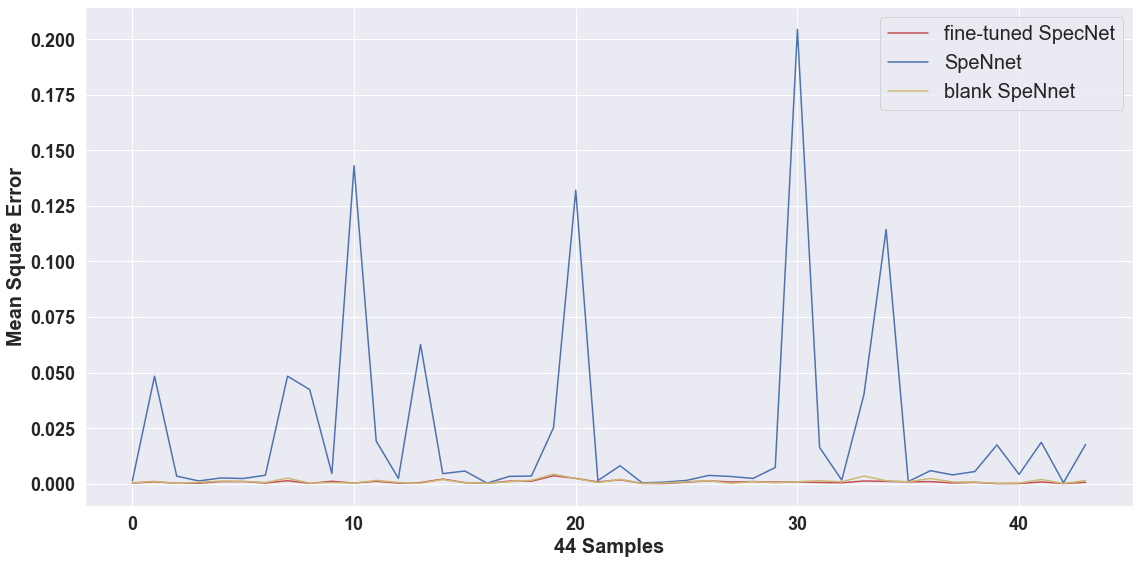

In [60]:
plt.figure(figsize=(16,8))
plt.plot(np.linspace(0,43,44),finetunedspecnet_mse_l,'r',label='fine-tuned SpecNet')
plt.plot(np.linspace(0,43,44),specnet_mse_l,'b',label='SpeNnet')
plt.plot(np.linspace(0,43,44),blank_specnet_mse_l,'y',label='blank SpeNnet')
# plt.plot(np.linspace(0,198,199),tf_mse_l,'b',label='our_model')
# plt.plot(np.linspace(0,198,199),specnet_mse_l,'g',label='Specnet')
# plt.title("simulated_w_10_500_20_04_003")
plt.ylabel("Mean Square Error",fontweight='bold',fontsize=20)
plt.yticks(fontweight='bold',fontsize=18)
plt.xlabel("44 Samples",fontweight='bold',fontsize=20)
plt.xticks(fontweight='bold',fontsize=18)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

In [61]:
# finding the mean of finetunedspecnet_mse_l and specnet_mse_l
finetunedspecnet_mse_np = np.array(finetunedspecnet_mse_l)
specnet_mse_np = np.array(specnet_mse_l)
blank_specnet_mse_np = np.array(blank_specnet_mse_l)
print("mean of finetunedspecnet_mse_np     :",np.mean(finetunedspecnet_mse_np))
print("mean of specnet_mse_np              :",np.mean(specnet_mse_np))
print("mean of blank_specnet_mse_np        :",np.mean(blank_specnet_mse_np))

mean of finetunedspecnet_mse_np     : 0.0007786743799644225
mean of specnet_mse_np              : 0.023621683866594776
mean of blank_specnet_mse_np        : 0.0010200378511951845


### predicting the experimental spectra using finetuned_SpecNet and SpecNet

In [62]:
# experimental spectra
exp_CARS_1 = pd.read_csv("exp_1_CDMP_CARS_Data_640_points4.csv",header=None)
exp_Raman_1 = pd.read_csv("exp_1_CDMP_Raman_Data_640_points_MEM4.csv",header=None)
exp_CARS_2 = pd.read_csv("exp_2_MECyeast_CARS_normalized.csv",header=None)
exp_Raman_2 = pd.read_csv("exp_2_MECyeast_Raman_normalized_MEM.csv",header=None)
exp_CARS_3 = pd.read_csv("exp_3_SAMD_CARS_Data_640_points.csv",header=None)
exp_Raman_3 = pd.read_csv("exp_3_SAMD_Raman_Data_640_points_MEM2.csv",header=None)

exp_4 = pd.read_csv("exp_4_proteindroplet_Data_640_points.csv",sep=';')
exp_4.drop('Column1',inplace=True,axis=1)
exp_4.rename(columns={'Column2':'Wavenumber','Column3':'CARS','Column4':'Raman'},inplace=True)
exp_CARS_4 = exp_4.rename(columns={"Wavenumber":"0","CARS":"1"})[['0','1']]
exp_CARS_4["0"] = exp_CARS_4["0"].str.replace(',','.')
exp_CARS_4["1"] = exp_CARS_4["1"].str.replace(',','.')
exp_Raman_4 = exp_4.rename(columns={"Wavenumber":"0","Raman":"1"})[['0','1']]
exp_Raman_4["0"] = exp_Raman_4["0"].str.replace(',','.')
exp_Raman_4["1"] = exp_Raman_4["1"].str.replace(',','.')

# exp_CARS_5 = pd.read_fwf('exp_CARS_5_ProteinDroplet_2.txt',header=None)
# exp_CARS_5.to_csv('exp_CARS_5_ProteinDroplet_2_Data_640_points.csv')
# exp_Raman_5 = pd.read_fwf('exp_Raman_5_ProteinDroplet_2.txt',header=None)
# exp_Raman_5.to_csv('exp_Raman_5_ProteinDroplet_2_Data_640_points.csv')
exp_CARS_5 = pd.read_fwf('exp_Raman_5_ProteinDroplet_2.txt',header=None)
exp_CARS_5.to_csv('exp_Raman_5_ProteinDroplet_2_Data_640_points.csv')
exp_Raman_5 = pd.read_fwf('exp_CARS_5_ProteinDroplet_2.txt',header=None)
exp_Raman_5.to_csv('exp_CARS_5_ProteinDroplet_2_Data_640_points.csv')

exp_6 = pd.read_fwf('exp_6_ProteinDroplet_3.txt')
exp_6.to_csv('exp_6_ProteinDroplet_3_Data_640_points.csv')
exp_6[['Wavenumber','CARS','Raman']] = exp_6[list(exp_6.columns)[0]].str.split("\t",expand=True)
exp_6 = exp_6.drop(list(exp_6.columns)[0],axis=1)
exp_CARS_6 = exp_6.rename(columns={"Wavenumber":"0","CARS":"1"})[['0','1']]
exp_Raman_6 = exp_6.rename(columns = {"Wavenumber":"0","Raman":"1"})[['0','1']]

# 640 data points
n_points = 640
nu = np.linspace(0,1,n_points)

#### exp_CARS_4_ProteinDroplet_1

In [69]:
# loading finetuned_SpecNet
# finetuned_SpecNet.load_weights("synthetic_w_10_500_20_04_003.h5")
#finetuned_SpecNet.load_weights("weights_semisynthetic_10_500_20_04_003.h5")
#finetuned_SpecNet.load_weights("weights_SpecNet_aug_semisynthetic_10_50.h5")
finetuned_SpecNet.load_weights("SpecNet_aug_semisynthetic_5_10_weights.h5")

# finetuned_SpecNet.load_weights("SpecNet_aug_semisynthetic_10_randomNRB_weights.h5")

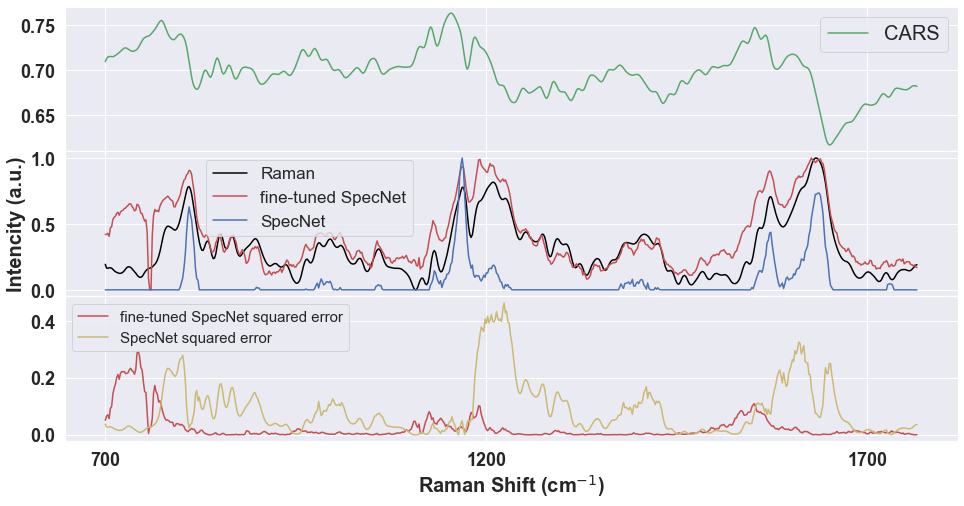

In [70]:
x_exp = np.empty((1,n_points,1))
y_exp = np.empty((1,n_points))

x_exp[0,:,0] = exp_CARS_4['1']
y_exp[0] = exp_Raman_4['1']
minmax_y_exp = (y_exp[0]-y_exp[0].min())/(y_exp[0].max()-y_exp[0].min())

y_hat = finetuned_SpecNet.predict(x_exp,verbose=0)
minmax_y_hat = (y_hat-y_hat.min())/(y_hat.max()-y_hat.min())
specnet_y_hat = SpecNet.predict(x_exp,verbose=0)
minmax_specnet_y_hat = (specnet_y_hat-specnet_y_hat.min())/(specnet_y_hat.max()-specnet_y_hat.min())


plt.figure(figsize=(16,8))
plt.subplot(3,1,1)
plt.plot(exp_CARS_4['0'],x_exp.flatten(),'g',label='CARS')
plt.xticks(exp_CARS_4['0'][::300],[700,1200,1700])
#plt.xticks([])
plt.yticks(fontweight='bold',fontsize=18)
plt.locator_params(axis='y',nbins=3)
plt.legend(fontsize=20)
plt.subplot(3,1,2)
plt.plot(exp_Raman_4['0'],minmax_y_exp.T,'black',label='Raman')
plt.plot(exp_Raman_4['0'],minmax_y_hat.T,'r',label='fine-tuned SpecNet')
plt.plot(exp_Raman_4['0'],minmax_specnet_y_hat.T,'b',label='SpecNet')
plt.xticks(exp_CARS_4['0'][::300],[700,1200,1700])
#plt.xticks([])
plt.ylabel("Intencity (a.u.)",fontweight='bold',fontsize=20)
plt.yticks(fontweight='bold',fontsize=18)
plt.locator_params(axis='y',nbins=3)
#plt.legend(prop=dict(weight='bold'),fontsize=20,loc=1,bbox_to_anchor=(0.35,1))
plt.legend(fontsize=17,loc=1,bbox_to_anchor=(0.40,1))
plt.subplot(3,1,3)
plt.plot(exp_Raman_4['0'],((minmax_y_hat-minmax_y_exp).T)**2,'r',label='fine-tuned SpecNet squared error')
plt.plot(exp_Raman_4['0'],((minmax_specnet_y_hat-minmax_y_exp).T)**2,'y',label='SpecNet squared error')
plt.yticks(fontweight='bold',fontsize=18)
plt.locator_params(axis='y',nbins=3)
plt.legend(fontsize=15)
plt.subplots_adjust(hspace=0)
plt.xlabel("Raman Shift (cm$^{-1}$)",fontweight='bold',fontsize=20)
plt.xticks(exp_CARS_4['0'][::300],[700,1200,1700])
plt.xticks(fontweight='bold',fontsize=18)
plt.show()